In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [7]:
weather_df = pd.read_csv("weather_data.csv")


weather_df['UV Index'] = pd.to_numeric(weather_df['UV Index'], errors='coerce')
print(weather_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13213 entries, 0 to 13212
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13169 non-null  float64
 1   Humidity              13178 non-null  float64
 2   Wind Speed            13175 non-null  float64
 3   Precipitation (%)     13180 non-null  float64
 4   Cloud Cover           13213 non-null  object 
 5   Atmospheric Pressure  13169 non-null  float64
 6   UV Index              13176 non-null  float64
 7   Season                13213 non-null  object 
 8   Visibility (km)       13166 non-null  float64
 9   Location              13213 non-null  object 
 10  Weather Type          13213 non-null  object 
 11  Irradiance            1333 non-null   float64
dtypes: float64(8), object(4)
memory usage: 1.2+ MB
None


In [8]:
nullValues = weather_df.isnull().sum()
duplicates = weather_df.duplicated().sum()
samples = weather_df.shape[0]

print(nullValues,nullValues.sum(), duplicates, samples)

Temperature                44
Humidity                   35
Wind Speed                 38
Precipitation (%)          33
Cloud Cover                 0
Atmospheric Pressure       44
UV Index                   37
Season                      0
Visibility (km)            47
Location                    0
Weather Type                0
Irradiance              11880
dtype: int64 12158 13 13213


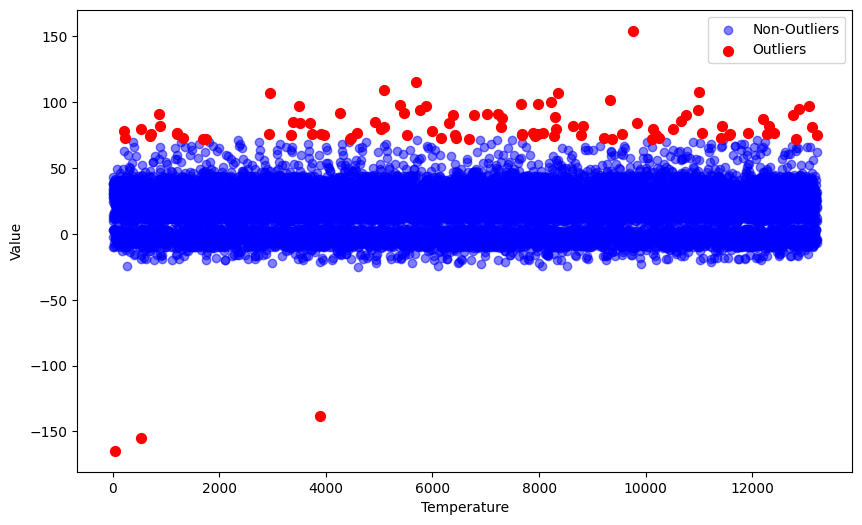

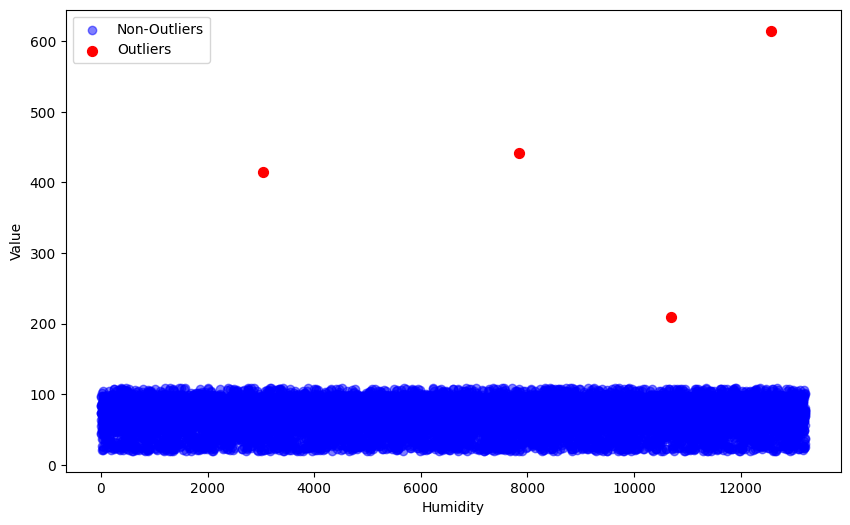

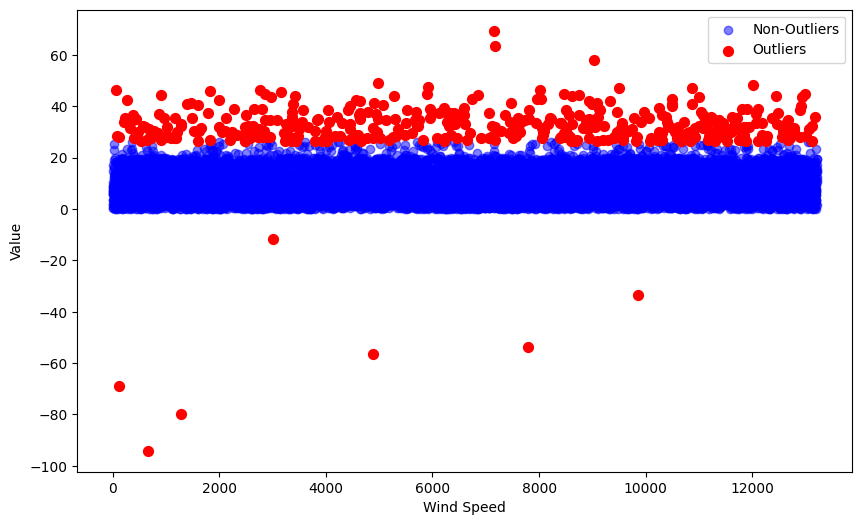

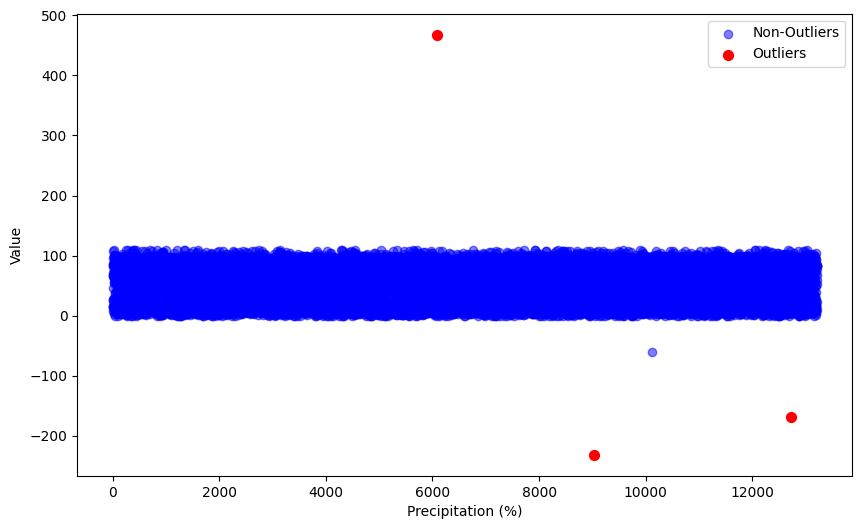

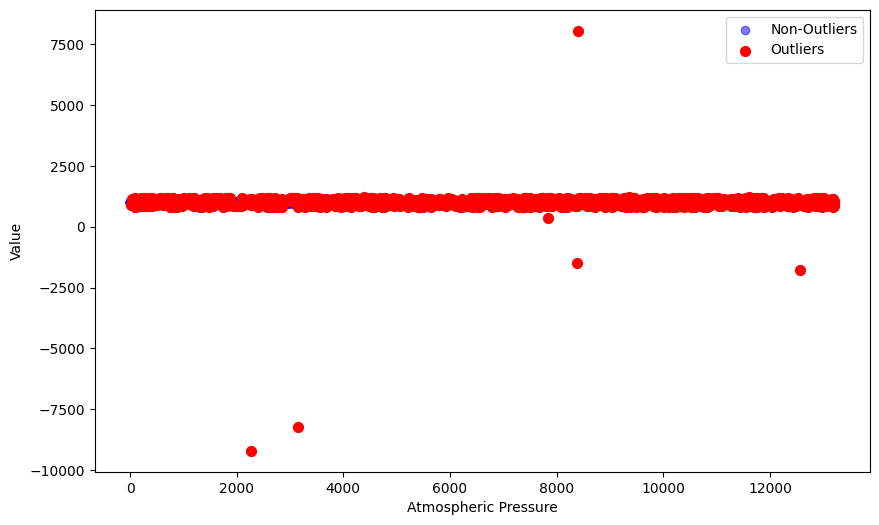

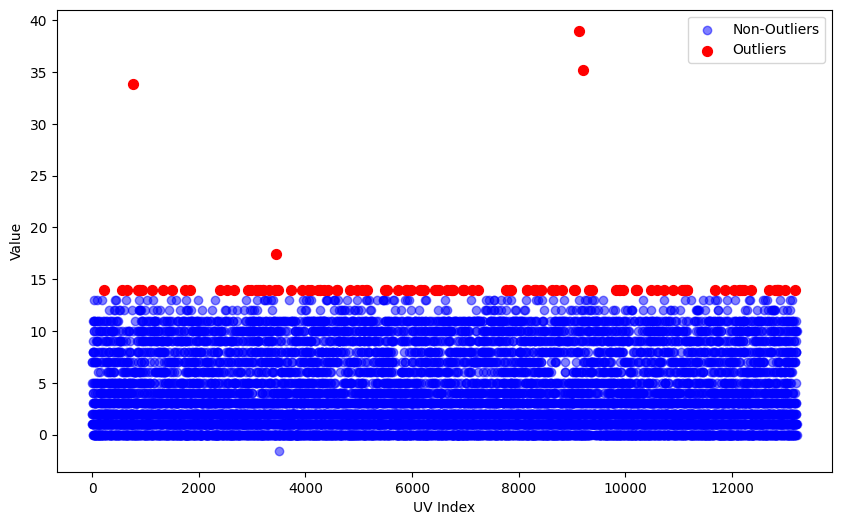

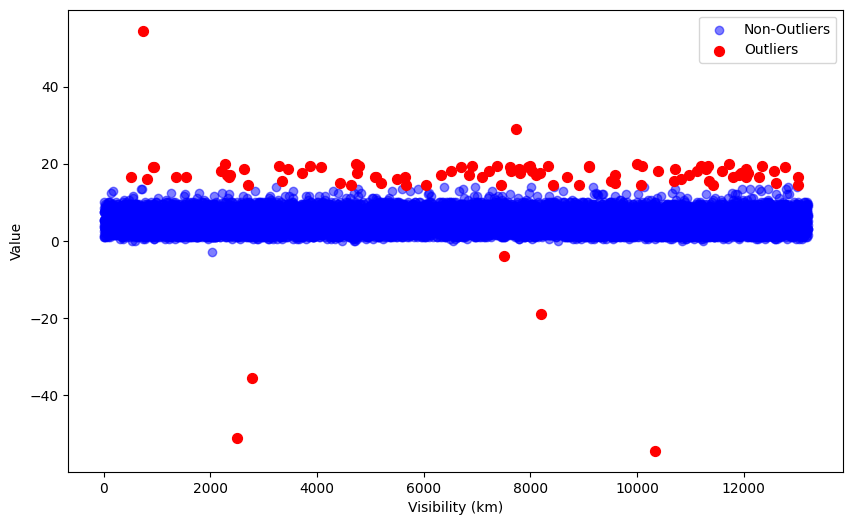

In [9]:
#detekcia a odstranenie outlierov
def detectOutliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outlier_columns = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Atmospheric Pressure','UV Index', 'Visibility (km)']

for column in outlier_columns:
    outliers = detectOutliers(weather_df, column)
    weather_df = weather_df.drop(outliers.index)
    
    plt.figure(figsize=(10,6))

    plt.scatter(weather_df.index, weather_df[column], color='blue', label='Non-Outliers', alpha=0.5)
    plt.scatter(outliers.index, outliers[column], color='red', label='Outliers', s=50)

    plt.xlabel(column)
    plt.ylabel("Values")
    plt.legend()
    plt.show()



In [6]:
#odstranenie stlpcov v ktorych je vela null hodnot a null hodnot
weather_df_cleaned = weather_df.drop('Irradiance', axis=1)
weather_df_cleaned = weather_df_cleaned.dropna()
weather_df_cleaned = weather_df_cleaned.drop_duplicates()

nullValues = weather_df_cleaned.isnull().sum()
duplicates = weather_df_cleaned.duplicated().sum()
samples = weather_df_cleaned.shape[0]

weather_df.reset_index(drop=True, inplace=True)
one_hot_encoded_columns = ['Cloud Cover', 'Season', 'Location']
weather_df_cleaned_encoded = weather_df_cleaned.copy()
for column in one_hot_encoded_columns:
    one_hot_encoded = pd.get_dummies(weather_df_cleaned_encoded[column])
    weather_df_cleaned_encoded = pd.concat([weather_df_cleaned_encoded.drop(columns=column), one_hot_encoded.astype(int)], axis = 1)

label_encoder = LabelEncoder()
weather_df_cleaned_encoded['Weather Type'] = label_encoder.fit_transform(weather_df_cleaned_encoded['Weather Type'])

print(nullValues, nullValues.sum(), duplicates, samples)



Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64 0 0 11300


In [7]:
X = weather_df_cleaned_encoded.drop('Weather Type', axis=1)
Y = weather_df_cleaned_encoded['Weather Type']

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size = 0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp , Y_temp, test_size = 0.5, random_state=42)

# plt.figure(figsize=(10,6))

#plt.hist(X_train['Temperature'], bins = 20, color = 'blue', alpha = 0.5)
#plt.show()



X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((7910, 19), (7910,), (1695, 19), (1695,), (1695, 19), (1695,))

In [8]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#X_train_df = pd.DataFrame(X_train)
#plt.hist(X_train_df[1], bins = 20, color = 'blue', alpha = 0.5)
#plt.show()


model accuracy: 0.9634218289085545


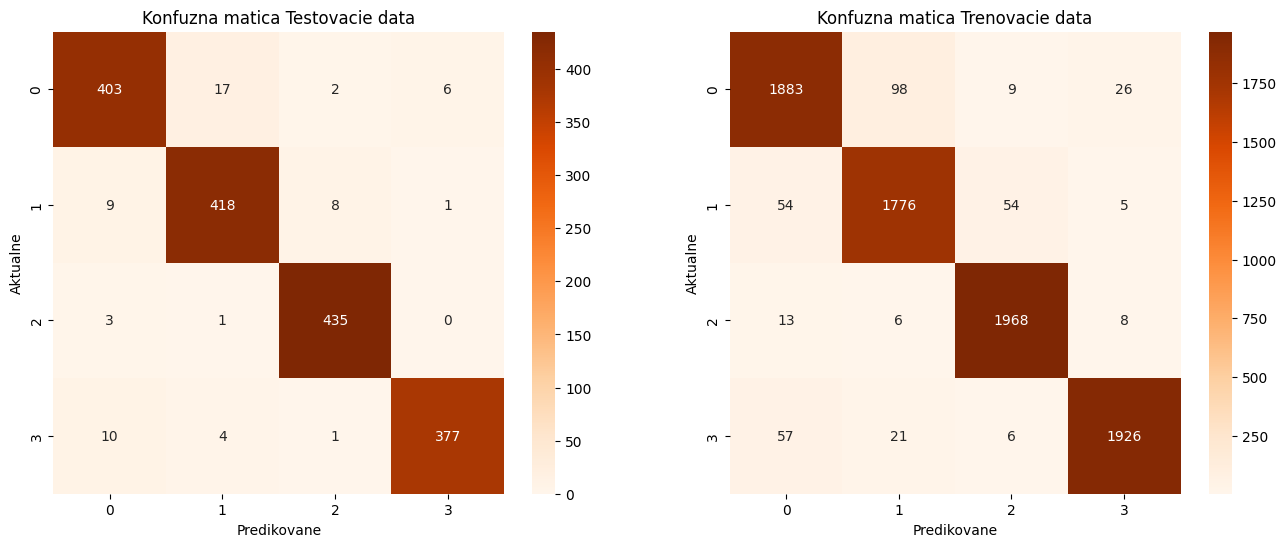

In [9]:
model = LogisticRegression(max_iter=200)
#print(X_train.isnull().sum(), X_train)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

accurracy = accuracy_score(Y_test, y_pred)
print(f"model accuracy: {accurracy}")

conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Konfuzna matica Testovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")


conf_matrix = confusion_matrix(Y_train, y_pred_train)
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Konfuzna matica Trenovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")
plt.show()

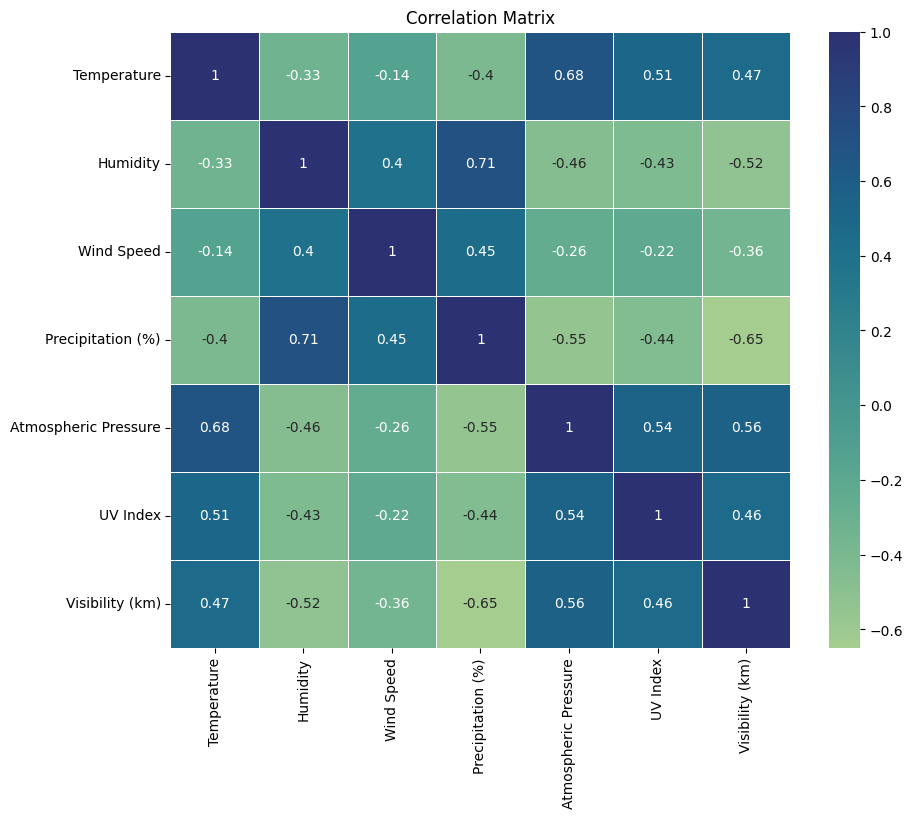

In [10]:
correlation_matrix = weather_df_cleaned.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', linewidths=0.5).set(title="Correlation Matrix")
plt.show()

/tmp/ipykernel_412/1338524379.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(temperature_by_season, x='Season', y='Temperature', palette="crest").set(title="Average temperature by cloud cover", ylabel="Average Temperature")


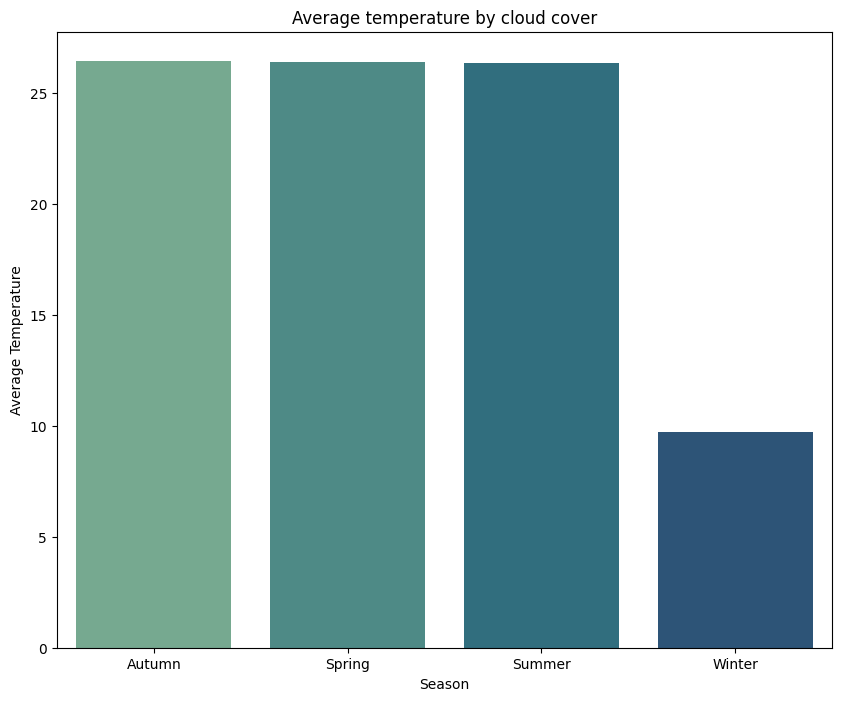

In [20]:
temperature_by_season = weather_df_cleaned.groupby('Cloud Cover')['Temperature'].mean().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(temperature_by_season, x='Cloud Cover', y='Temperature', palette="crest").set(title="Average temperature by cloud cover", ylabel="Average Temperature")
plt.show()

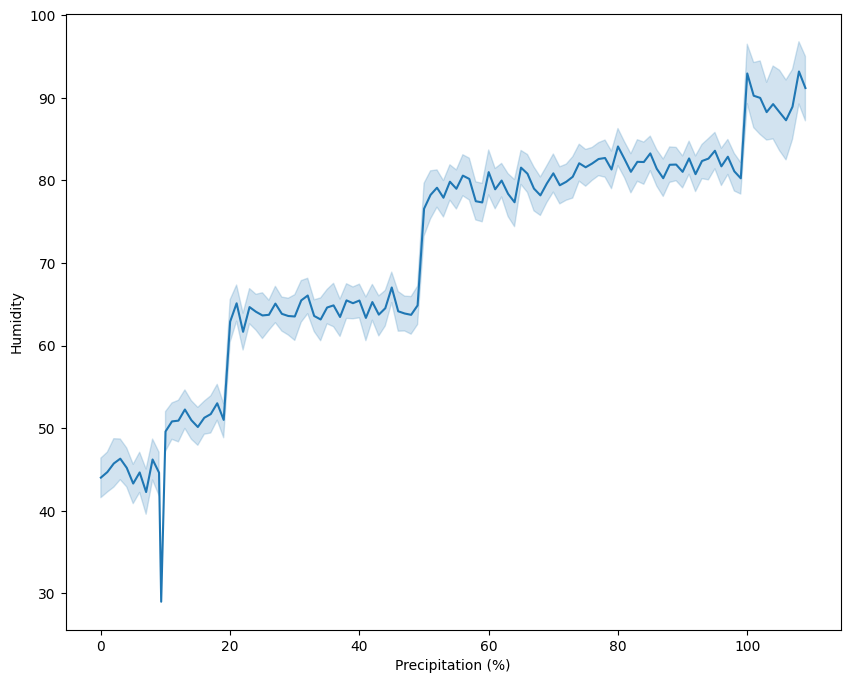

In [12]:
plt.figure(figsize=(10, 8))
sns.lineplot(weather_df_cleaned, x='Precipitation (%)', y='Humidity')
plt.show()

<Figure size 1000x800 with 0 Axes>

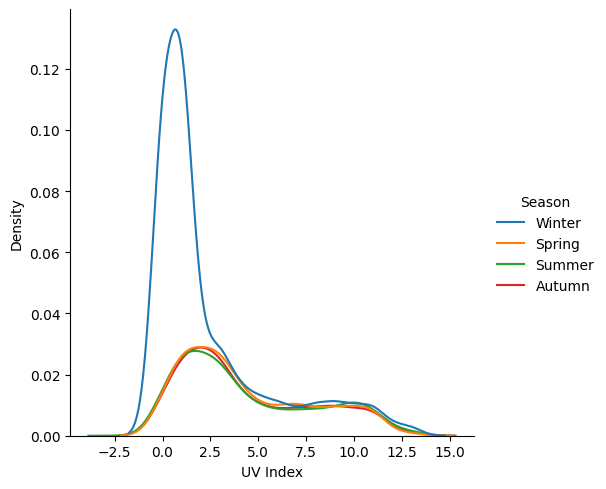

In [13]:
plt.figure(figsize=(10, 8))
sns.displot(weather_df_cleaned, x='UV Index', hue="Season", kind="kde")
plt.show()

<Figure size 2000x800 with 0 Axes>

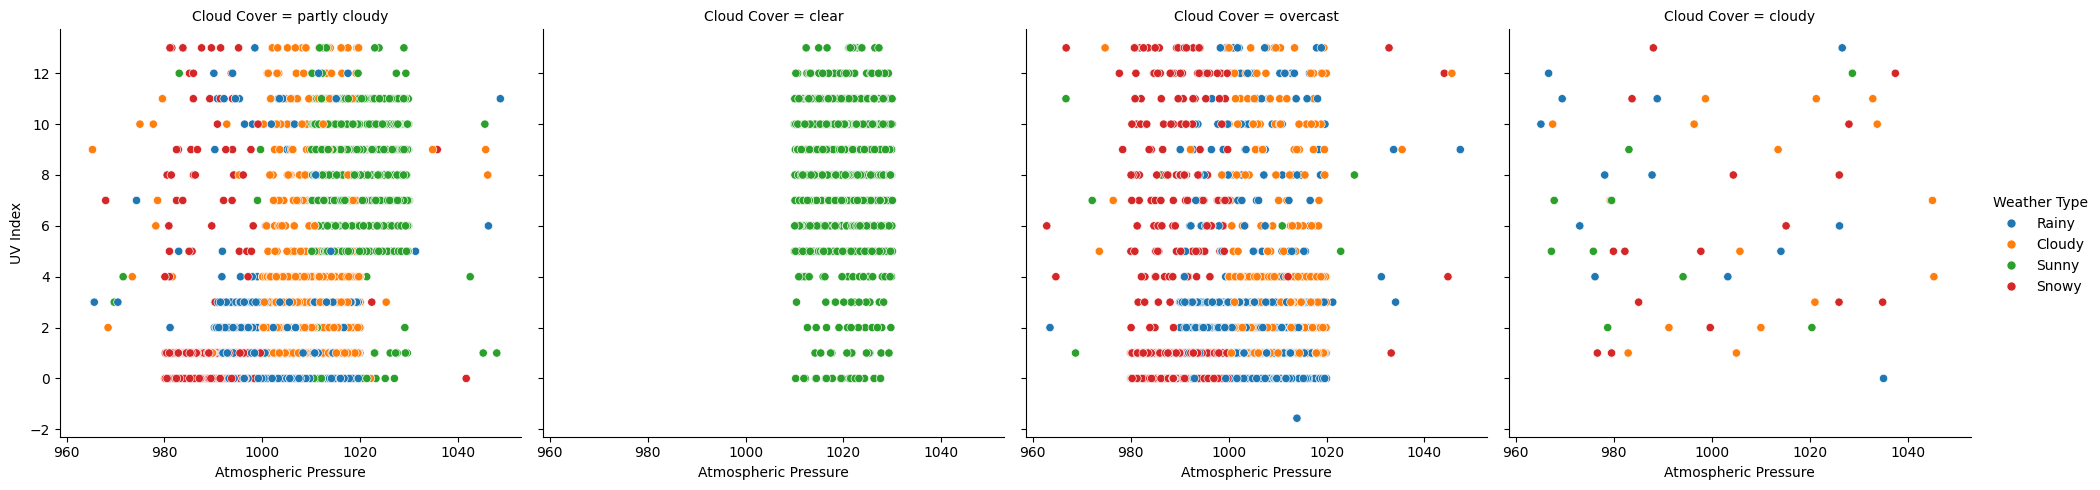

In [14]:
plt.figure(figsize=(20, 8))
sns.relplot(weather_df_cleaned, x='Atmospheric Pressure', y='UV Index', hue="Weather Type", col="Cloud Cover")
plt.show()

In [42]:
one_hot_encoded_columns = ['Cloud Cover', 'Season', 'Location', 'Weather Type']
weather_df_cleaned_encoded = weather_df_cleaned.copy()
for column in one_hot_encoded_columns:
    one_hot_encoded = pd.get_dummies(weather_df_cleaned_encoded[column])
    weather_df_cleaned_encoded = pd.concat([weather_df_cleaned_encoded.drop(columns=column), one_hot_encoded.astype(int)], axis = 1)

X = weather_df_cleaned_encoded.drop(['Sunny', 'Rainy', 'Cloudy', 'Snowy'], axis=1)
Y = weather_df_cleaned_encoded[['Rainy', 'Cloudy', 'Sunny', 'Snowy']]

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size = 0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp , Y_temp, test_size = 0.5, random_state=42)



scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(100, input_shape=(19,), activation='relu'))
model.add(tf.keras.layers.Dense(80, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=1000, batch_size=1024, verbose=1, validation_data=(X_val, Y_val))#, callbacks=[early_stopping])

loss, accurracy = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {accurracy:.4f}')

Num GPUs Available:  1
Epoch 1/1000


/home/des/suns/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-13 19:29:36.957885: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_388', 32 bytes spill stores, 32 bytes spill loads

2024-10-13 19:29:37.614757: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_392', 500 bytes spill stores, 500 bytes spill loads

2024-10-13 19:29:37.921196: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_390', 14

1/8 ━━━━━━━━━━━━━━━━━━━━ 52s 8s/step - accuracy: 0.3105 - loss: 1.3988

2024-10-13 19:29:43.563843: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_205', 32 bytes spill stores, 32 bytes spill loads

2024-10-13 19:29:43.612526: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_388', 104 bytes spill stores, 104 bytes spill loads

2024-10-13 19:29:45.625184: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_388', 236 bytes spill stores, 240 bytes spill loads

2024-10-13 19:29:45.682129: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_390', 56 bytes spill stores, 56 bytes spill loads

2024-10-13 19:29:45.829227: I external/local_xla/xla/stream_

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3640 - loss: 1.3604 

2024-10-13 19:29:50.260588: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_59', 32 bytes spill stores, 32 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3711 - loss: 1.3567 - val_accuracy: 0.6295 - val_loss: 1.2359
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6879 - loss: 1.1853 - val_accuracy: 0.7186 - val_loss: 1.0560
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7375 - loss: 0.9922 - val_accuracy: 0.7681 - val_loss: 0.8487
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8015 - loss: 0.7818 - val_accuracy: 0.8012 - val_loss: 0.6529
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8165 - loss: 0.5977 - val_accuracy: 0.8307 - val_loss: 0.5076
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8584 - loss: 0.4543 - val_accuracy: 0.8773 - val_loss: 0.4058
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8940 - loss: 0.3616 - val_accuracy: 0.9038 - val_loss: 0.3389
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9180 - loss: 0.2988 - val_accuracy: 0.9215 - val_loss: 0.2970
Epoch

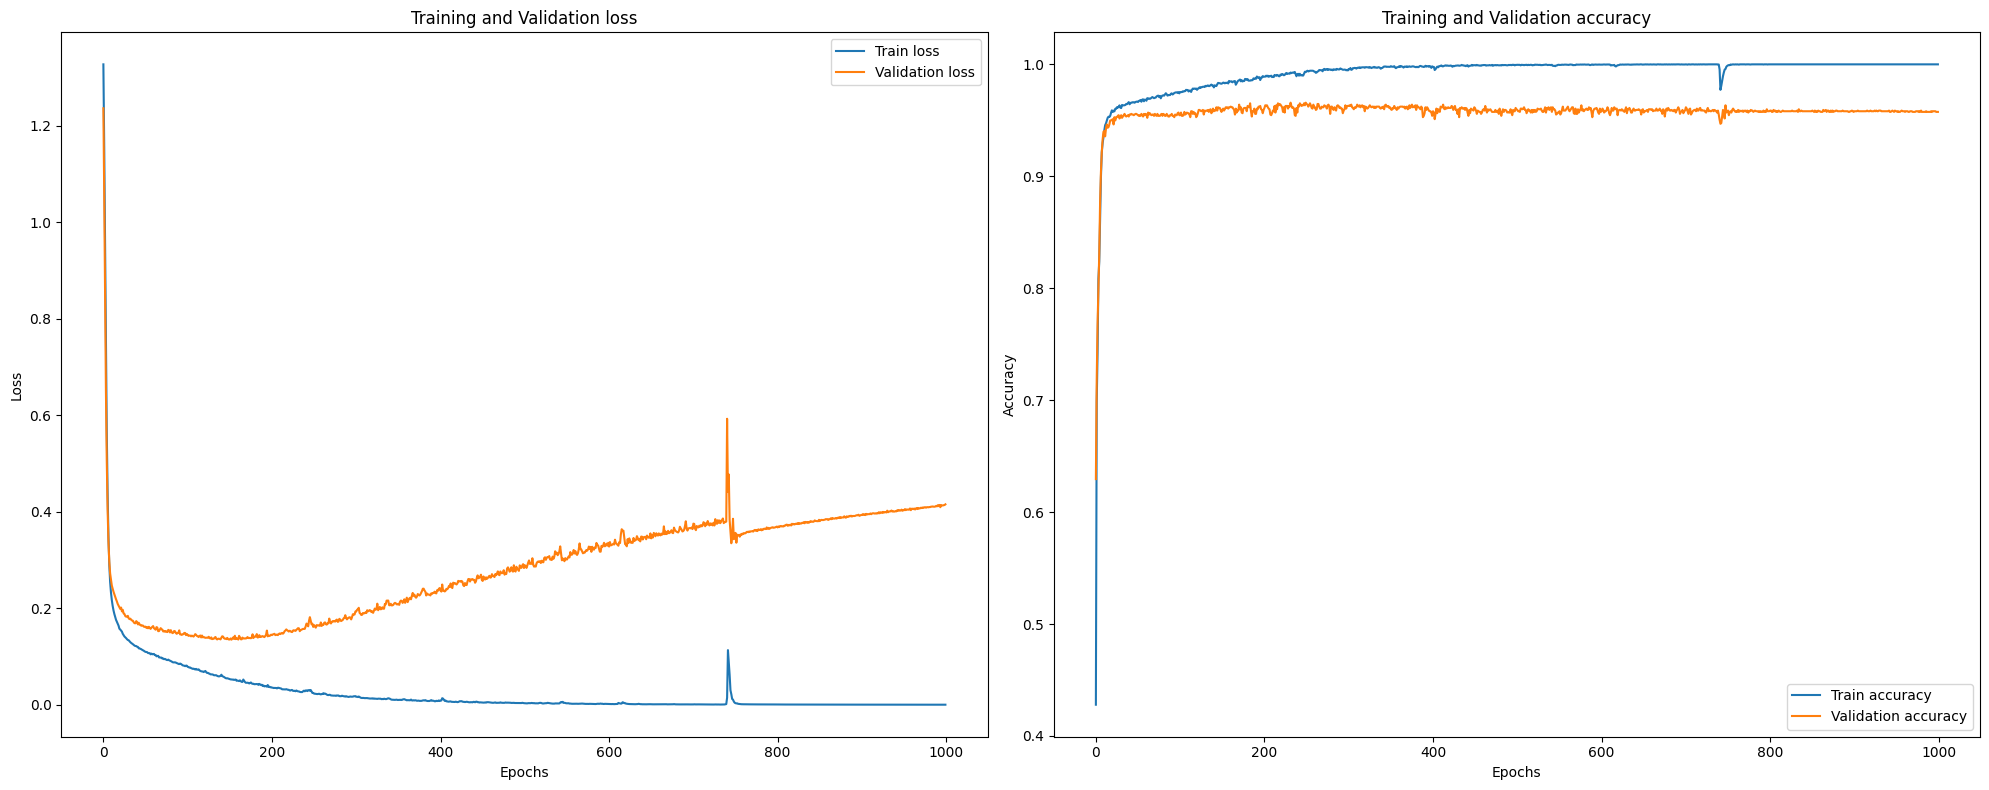

In [43]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label="Train loss")
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], label="Train accuracy")
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


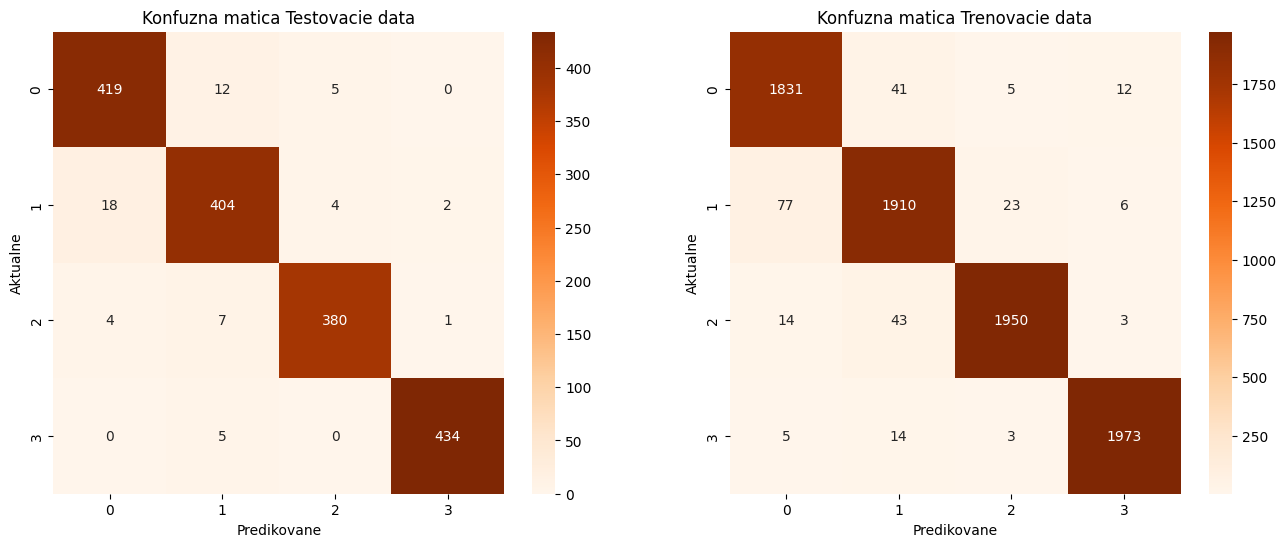

In [33]:

y_pred = np.argmax(model.predict(X_test), axis=1) 
Y_test_conf =np.argmax(Y_test, axis=1)
conf_matrix = confusion_matrix(Y_test_conf, y_pred)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=range(len(np.unique(Y_test_conf))), yticklabels=range(len(np.unique(Y_test_conf))))
plt.title("Konfuzna matica Testovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")


y_pred = np.argmax(model.predict(X_train), axis=1) 
Y_train_conf =np.argmax(Y_train, axis=1)
conf_matrix = confusion_matrix(Y_train_conf, y_pred)
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=range(len(np.unique(Y_train_conf))), yticklabels=range(len(np.unique(Y_train_conf))))
plt.title("Konfuzna matica Trenovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")
plt.show()